In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from xgboost import plot_importance, plot_tree
from matplotlib import pyplot
from skopt import BayesSearchCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.calibration import calibration_curve
import time

pd.set_option("display.max_columns", 75)

### Data Import and Pre-processing

In [2]:
atp_df = pd.read_csv('ATP.csv', low_memory=False)

In [3]:
atp_df.describe()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
count,163966,163966,161399,163966,163966,163966,163966,163966,63019,13920,163966,163935,145981,163966,160523,139317,139317,163966,31499,24102,163966,163915,134718,163966,157407,136169,136169,163791,163966,163966,74878,77401,77401,77401,77401,77401,77401,77401,77401,77401,77401,77401,77401,77401,77401,77401,77401,77401,77401
unique,7048,3533,5,17,7,2758,416,3517,35,6,3510,4,24,127,7541,1174,3853,5547,36,7,5535,4,24,136,8337,1393,3710,20406,3,16,317,57,25,239,162,129,64,43,26,35,55,26,249,172,132,65,44,30,37
top,2008-560,Wimbledon,Hard,32,A,19710901,2,100284,1,Q,Jimmy Connors,R,183,USA,22.8254620123,1,0,102148,8,Q,Fabrice Santoro,R,183,USA,24.5201916496,44,0,6-4 6-4,3,R32,70,3,1,55,32,27,14,10,0,3,2,2,57,36,24,11,9,3,7
freq,127,6223,63821,67344,106804,189,3607,1229,9547,8880,1229,137941,21979,35047,111,2830,52025,444,2955,15125,444,137294,20287,31452,81,987,50030,4893,126957,54106,1077,8145,16437,1347,2032,2958,5010,11372,12177,8701,10692,13975,1368,2031,2606,4783,11461,10579,8471


In [4]:
# Remove row of header labels in the middle of the dataset
atp_df = atp_df[atp_df['tourney_name'] != 'tourney_name']

In [5]:
# Define data types
atp_dtype_dict = {'tourney_id': 'object', 'tourney_name': 'object', 
                  'surface': 'object', 'draw_size': 'float64', 
                  'tourney_level': 'object','tourney_date': 'datetime64', 
                  'match_num': 'float64', 'winner_id': 'object', 
                  'winner_seed': 'float64', 'winner_entry': 'object',
                  'winner_name': 'object', 'winner_hand': 'object', 
                  'winner_ht': 'float64', 'winner_ioc': 'object', 
                  'winner_age': 'float64', 'winner_rank': 'float64', 
                  'winner_rank_points': 'float64', 'loser_id': 'object', 
                  'loser_seed': 'float64', 'loser_entry': 'object', 
                  'loser_name': 'object', 'loser_hand': 'object', 
                  'loser_ht': 'float64', 'loser_ioc': 'object', 
                  'loser_age': 'float64', 'loser_rank': 'float64', 
                  'loser_rank_points': 'float64', 'score': 'object', 
                  'best_of': 'float64','round': 'object', 'minutes': 'float64', 
                  'w_ace': 'float64', 'w_df': 'float64', 'w_svpt': 'float64', 
                  'w_1stIn': 'float64', 'w_1stWon': 'float64',
                  'w_2ndWon': 'float64', 'w_SvGms': 'float64', 
                  'w_bpSaved': 'float64', 'w_bpFaced': 'float64', 
                  'l_ace': 'float64', 'l_df': 'float64','l_svpt': 'float64', 
                  'l_1stIn': 'float64', 'l_1stWon': 'float64', 
                  'l_2ndWon': 'float64', 'l_SvGms': 'float64', 
                  'l_bpSaved': 'float64','l_bpFaced': 'float64'}


atp_df = atp_df.astype(dtype=atp_dtype_dict).sort_values(by=['tourney_date', 'match_num'])
atp_df['tourney_year'] = atp_df['tourney_date'].dt.year

# Initial data profile
atp_profile = pandas_profiling.ProfileReport(atp_df, correlation_threshold=1.0, bins=20)
atp_profile.to_file(outputfile="atp_initial_profile.html")
# atp_profile

# print(atp_df.dtypes)

In [6]:
atp_df.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'winner_rank', 'winner_rank_points', 'loser_id', 'loser_seed',
       'loser_entry', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc',
       'loser_age', 'loser_rank', 'loser_rank_points', 'score', 'best_of',
       'round', 'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon',
       'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df',
       'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved',
       'l_bpFaced', 'tourney_year'],
      dtype='object')

In [7]:
atp_df.shape

(163965, 50)

### Data Exploration Visualization

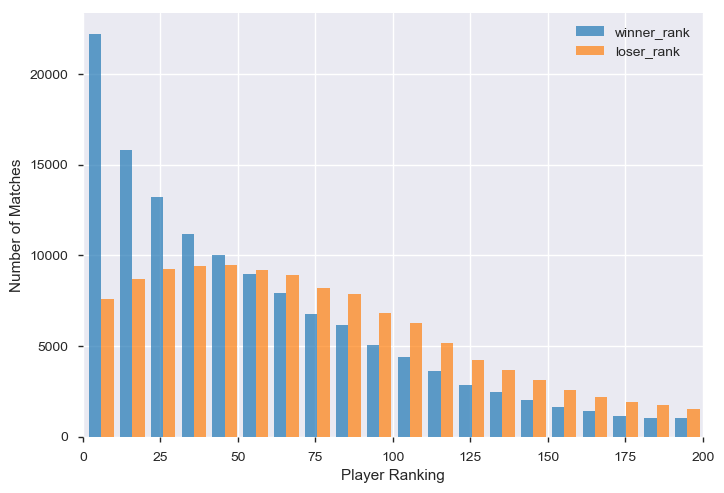

In [8]:
fig, ax = pyplot.subplots()

winner_ranks = atp_df['winner_rank']
loser_ranks = atp_df['loser_rank']

ax.hist([winner_ranks[winner_ranks <= 200], 
         loser_ranks[loser_ranks <= 200]], 20, alpha=0.7, label=['winner_rank', 'loser_rank'])

ax.set_ylabel("Number of Matches")
ax.set_xlabel("Player Ranking")
# ax.set_title("Comparison of winner_rank and loser_rank distributions")
ax.legend(loc='upper right')
ax.set_xlim(0,200)
pyplot.show()


#### Data Exploration and Cleaning

In [9]:
atp_df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,tourney_year
0,1968-580,Australian Chps.,Grass,64.0,G,1968-01-19,1.0,110023,NaN,NaN,Richard Coulthard,R,NaN,AUS,NaN,NaN,NaN,107760,NaN,NaN,Max Senior,R,NaN,AUS,NaN,NaN,NaN,12-10 7-5 4-6 7-5,5.0,R64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
1,1968-580,Australian Chps.,Grass,64.0,G,1968-01-19,2.0,109803,NaN,NaN,John Brown,R,NaN,AUS,27.520876,NaN,NaN,106964,NaN,NaN,Ernie Mccabe,R,NaN,AUS,NaN,NaN,NaN,6-3 6-2 6-4,5.0,R64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
2,1968-580,Australian Chps.,Grass,64.0,G,1968-01-19,3.0,100257,NaN,NaN,Ross Case,R,NaN,AUS,16.216290,NaN,NaN,110024,15.0,NaN,Gondo Widjojo,R,NaN,INA,NaN,NaN,NaN,6-4 3-6 6-3 7-5,5.0,R64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
3,1968-580,Australian Chps.,Grass,64.0,G,1968-01-19,4.0,100105,5.0,NaN,Allan Stone,R,NaN,AUS,22.264203,NaN,NaN,110025,NaN,NaN,Robert Layton,R,NaN,AUS,NaN,NaN,NaN,6-4 6-2 6-1,5.0,R64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
4,1968-580,Australian Chps.,Grass,64.0,G,1968-01-19,5.0,109966,NaN,NaN,Warren Jacques,R,NaN,AUS,29.861739,NaN,NaN,110026,NaN,NaN,Bert Kearney,R,NaN,AUS,NaN,NaN,NaN,6-4 6-1 7-5,5.0,R64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
5,1968-580,Australian Chps.,Grass,64.0,G,1968-01-19,6.0,107759,NaN,NaN,Max Pettman,R,NaN,AUS,NaN,NaN,NaN,110027,NaN,NaN,Takesji Tsujimoto,R,NaN,JPN,NaN,NaN,NaN,6-4 6-1 6-2,5.0,R64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
6,1968-580,Australian Chps.,Grass,64.0,G,1968-01-19,7.0,100101,12.0,NaN,Mike Belkin,R,NaN,CAN,22.557153,NaN,NaN,110028,NaN,NaN,M Marchment,R,NaN,AUS,NaN,NaN,NaN,6-2 3-6 6-4 9-7,5.0,R64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
7,1968-580,Australian Chps.,Grass,64.0,G,1968-01-19,8.0,100025,3.0,NaN,Barry Phillips Moore,R,173.0,AUS,30.529774,NaN,NaN,108430,NaN,NaN,Tony Dawson,R,NaN,AUS,NaN,NaN,NaN,6-3 6-0 6-3,5.0,R64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
8,1968-580,Australian Chps.,Grass,64.0,G,1968-01-19,9.0,108519,NaN,NaN,William Coghlan,R,NaN,AUS,NaN,NaN,NaN,110029,NaN,NaN,Peter Oatey,R,NaN,AUS,NaN,NaN,NaN,6-0 6-2 9-11 6-3,5.0,R64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
9,1968-580,Australian Chps.,Grass,64.0,G,1968-01-19,10.0,109799,NaN,NaN,Geoff Pollard,R,NaN,AUS,34.001369,NaN,NaN,110030,NaN,NaN,Christian Janssens,R,NaN,BEL,NaN,NaN,NaN,6-4 6-2 6-4,5.0,R64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968


In [10]:
# Drop unneccesary features
atp_df.drop(['tourney_id', 'tourney_name', 'match_num', 'winner_name',
             'loser_name', 'winner_ioc', 'loser_ioc', 'score','winner_entry', 
             'loser_entry', 'winner_seed', 'loser_seed',
             'winner_ht', 'loser_ht'], axis=1, inplace=True)
atp_df

,surface,draw_size,tourney_level,tourney_date,winner_id,winner_hand,winner_age,winner_rank,winner_rank_points,loser_id,loser_hand,loser_age,loser_rank,loser_rank_points,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,tourney_year
0,Grass,64.0,G,1968-01-19,110023,R,NaN,NaN,NaN,107760,R,NaN,NaN,NaN,5.0,R64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
1,Grass,64.0,G,1968-01-19,109803,R,27.520876,NaN,NaN,106964,R,NaN,NaN,NaN,5.0,R64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
2,Grass,64.0,G,1968-01-19,100257,R,16.216290,NaN,NaN,110024,R,NaN,NaN,NaN,5.0,R64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
3,Grass,64.0,G,1968-01-19,100105,R,22.264203,NaN,NaN,110025,R,NaN,NaN,NaN,5.0,R64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
4,Grass,64.0,G,1968-01-19,109966,R,29.861739,NaN,NaN,110026,R,NaN,NaN,NaN,5.0,R64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
5,Grass,64.0,G,1968-01-19,107759,R,NaN,NaN,NaN,110027,R,NaN,NaN,NaN,5.0,R64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
6,Grass,64.0,G,1968-01-19,100101,R,22.557153,NaN,NaN,110028,R,NaN,NaN,NaN,5.0,R64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
7,Grass,64.0,G,1968-01-19,100025,R,30.529774,NaN,NaN,108430,R,NaN,NaN,NaN,5.0,R64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
8,Grass,64.0,G,1968-01-19,108519,R,NaN,NaN,NaN,110029,R,NaN,NaN,NaN,5.0,R64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
9,Grass,64.0,G,1968-01-19,109799,R,34.001369,NaN,NaN,110030,R,NaN,NaN,NaN,5.0,R64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968


In [11]:
# Drop matches with missing values and reset index
atp_filtered_df = atp_df.dropna().copy()
atp_filtered_df.reset_index(drop=True, inplace=True)
atp_filtered_df['match_id'] = atp_filtered_df.index
atp_filtered_df.shape

# Create data profile
atp_filtered_profile = pandas_profiling.ProfileReport(atp_filtered_df, correlation_threshold=1.0, bins=20)
atp_filtered_profile.to_file(outputfile="atp_filtered_profile.html")

In [12]:
# Filter out 2 matches with negative 'l_bpSaved' values
atp_filtered_df = atp_filtered_df[atp_filtered_df['l_bpSaved'] >= 0]

In [13]:
atp_filtered_df

,surface,draw_size,tourney_level,tourney_date,winner_id,winner_hand,winner_age,winner_rank,winner_rank_points,loser_id,loser_hand,loser_age,loser_rank,loser_rank_points,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,tourney_year,match_id
0,Hard,32.0,A,1991-01-07,101142,R,25.609856,9.0,1487.0,101746,R,20.643395,78.0,459.0,3.0,R32,63.0,1.0,0.0,53.0,37.0,30.0,7.0,9.0,5.0,6.0,3.0,0.0,46.0,30.0,17.0,7.0,8.0,2.0,6.0,1991,0
1,Hard,32.0,A,1991-01-07,100923,R,27.655031,55.0,555.0,100656,R,30.836413,3.0,2581.0,3.0,R32,88.0,1.0,3.0,68.0,47.0,33.0,9.0,10.0,2.0,4.0,5.0,1.0,82.0,47.0,31.0,21.0,10.0,6.0,6.0,1991,1
2,Hard,32.0,A,1991-01-07,101613,R,21.549624,94.0,371.0,100587,R,31.816564,220.0,114.0,3.0,R32,72.0,5.0,1.0,56.0,25.0,17.0,20.0,9.0,1.0,2.0,4.0,7.0,56.0,30.0,22.0,6.0,8.0,7.0,11.0,1991,2
3,Hard,32.0,A,1991-01-07,101196,R,25.201916,49.0,604.0,101511,R,22.376454,25.0,899.0,3.0,R32,67.0,5.0,3.0,48.0,35.0,28.0,5.0,8.0,3.0,4.0,0.0,2.0,64.0,48.0,23.0,7.0,8.0,6.0,11.0,1991,3
4,Hard,32.0,A,1991-01-07,101179,R,25.322382,77.0,468.0,101601,R,21.697467,212.0,116.0,3.0,R32,101.0,2.0,4.0,80.0,55.0,35.0,16.0,12.0,2.0,4.0,1.0,3.0,68.0,43.0,24.0,14.0,11.0,4.0,8.0,1991,4
5,Hard,32.0,A,1991-01-07,101073,R,26.245038,36.0,747.0,101703,R,20.895277,85.0,427.0,3.0,R32,68.0,10.0,3.0,53.0,32.0,29.0,12.0,10.0,1.0,1.0,1.0,2.0,55.0,26.0,20.0,16.0,10.0,2.0,4.0,1991,5
6,Hard,32.0,A,1991-01-07,101117,R,25.826146,65.0,502.0,101332,L,23.854894,72.0,483.0,3.0,R32,108.0,0.0,1.0,82.0,55.0,35.0,14.0,13.0,6.0,10.0,3.0,2.0,96.0,61.0,38.0,15.0,13.0,8.0,12.0,1991,6
7,Hard,32.0,A,1991-01-07,101772,R,20.511978,21.0,1003.0,101609,R,21.598905,26.0,893.0,3.0,R32,64.0,3.0,2.0,36.0,21.0,18.0,10.0,7.0,0.0,0.0,4.0,5.0,70.0,38.0,22.0,10.0,7.0,16.0,21.0,1991,7
8,Hard,32.0,A,1991-01-07,101901,R,19.709788,190.0,142.0,101735,R,20.695414,28.0,876.0,3.0,R32,65.0,4.0,4.0,65.0,46.0,34.0,12.0,10.0,2.0,2.0,1.0,3.0,49.0,25.0,21.0,12.0,9.0,4.0,6.0,1991,8
9,Hard,32.0,A,1991-01-07,101098,L,26.006845,16.0,1101.0,100855,R,28.364134,47.0,638.0,3.0,R32,70.0,6.0,4.0,58.0,27.0,24.0,17.0,9.0,3.0,3.0,6.0,6.0,52.0,28.0,15.0,16.0,9.0,2.0,5.0,1991,9


#### Split out player stats and remove winner/loser labels

In [14]:
player_stats_w_df = atp_filtered_df[['match_id', 'winner_id', 'winner_hand', 'winner_age', 
                                     'winner_rank', 'winner_rank_points', 'minutes', 'w_ace',
                                     'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 
                                     'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'surface', 
                                     'tourney_date', 'tourney_year', 'l_bpFaced', 'l_bpSaved',
                                     'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'loser_id', 
                                     'l_SvGms']].copy()

# Assign player 1/2 labels
np.random.seed(seed=1)
player_stats_w_df['player_label'] = np.random.randint(1, 3, player_stats_w_df.shape[0])

player_stats_w_df = player_stats_w_df.rename({'winner_id': 'player_id', 
                                              'winner_hand': 'hand',
                                              'winner_age': 'age',
                                              'winner_rank': 'rank',
                                              'winner_rank_points': 'rank_points',
                                              'w_ace': 'ace',
                                              'w_df': 'df',
                                              'w_svpt': 'svpt',
                                              'w_1stIn': '1stIn',
                                              'w_1stWon': '1stWon',
                                              'w_2ndWon': '2ndWon',
                                              'w_SvGms': 'SvGms',
                                              'w_bpSaved': 'bpSaved',
                                              'w_bpFaced': 'bpFaced', 
                                              'l_SvGms': 'RtGms',
                                              'l_bpFaced': 'bpOpp',
                                              'l_bpSaved': 'bpFailedOpp',
                                              'l_svpt': 'rtpt',
                                              'l_1stIn': 'rtpt1st',
                                              'l_1stWon': 'rtpt1stLost',
                                              'l_2ndWon': 'rtpt2ndLost',
                                              'loser_id': 'opponent_id'
                                             }, 
                                             axis='columns')

# Create intermediate features
player_stats_w_df['won_match'] = 1
player_stats_w_df['bpWon'] = player_stats_w_df['bpOpp'] - player_stats_w_df['bpFailedOpp']
player_stats_w_df['rtpt1stWon'] = player_stats_w_df['rtpt1st'] - player_stats_w_df['rtpt1stLost']
player_stats_w_df['svpt2nd'] = player_stats_w_df['svpt'] - player_stats_w_df['1stIn']
player_stats_w_df['rtpt2nd'] = player_stats_w_df['rtpt'] - player_stats_w_df['rtpt1st']
player_stats_w_df['rtpt2ndWon'] = player_stats_w_df['rtpt2nd'] - player_stats_w_df['rtpt2ndLost']


winner_labels = player_stats_w_df[['player_label']].rename({'player_label':'winner_label'}, 
                                                            axis='columns').copy()

player_stats_l_df = atp_filtered_df[['match_id', 'loser_id', 'loser_hand', 
                                     'loser_age', 'loser_rank','loser_rank_points', 
                                     'minutes', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 
                                     'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved',
                                     'l_bpFaced', 'surface', 'tourney_date', 'tourney_year',
                                     'w_bpFaced', 'w_bpSaved', 'w_svpt', 'w_1stIn', 
                                     'w_1stWon', 'w_2ndWon', 'winner_id', 'w_SvGms']].copy()

player_stats_l_df = player_stats_l_df.rename({'loser_id': 'player_id', 
                                              'loser_hand': 'hand',
                                              'loser_age': 'age',
                                              'loser_rank': 'rank',
                                              'loser_rank_points': 'rank_points',
                                              'l_ace': 'ace',
                                              'l_df': 'df',
                                              'l_svpt': 'svpt',
                                              'l_1stIn': '1stIn',
                                              'l_1stWon': '1stWon',
                                              'l_2ndWon': '2ndWon',
                                              'l_SvGms': 'SvGms',
                                              'l_bpSaved': 'bpSaved',
                                              'l_bpFaced': 'bpFaced',
                                              'w_SvGms': 'RtGms',
                                              'w_bpFaced': 'bpOpp',
                                              'w_bpSaved': 'bpFailedOpp',
                                              'w_svpt': 'rtpt',
                                              'w_1stIn': 'rtpt1st',
                                              'w_1stWon': 'rtpt1stLost',
                                              'w_2ndWon': 'rtpt2ndLost',
                                              'winner_id': 'opponent_id'
                                             }, 
                                             axis='columns')

# Assign player 1/2 labels
player_stats_l_df = player_stats_l_df.merge(winner_labels, how='outer', 
                                            left_index=True, right_index=True)

player_stats_l_df['player_label'] = np.where(player_stats_l_df['winner_label'] == 1, 2, 1)

player_stats_l_df.drop(['winner_label'], axis=1, inplace=True)

# Create intermediate features
player_stats_l_df['won_match'] = 0
player_stats_l_df['bpWon'] = player_stats_l_df['bpOpp'] - player_stats_l_df['bpFailedOpp']
player_stats_l_df['rtpt1stWon'] = player_stats_l_df['rtpt1st'] - player_stats_l_df['rtpt1stLost']
player_stats_l_df['svpt2nd'] = player_stats_l_df['svpt'] - player_stats_l_df['1stIn']
player_stats_l_df['rtpt2nd'] = player_stats_l_df['rtpt'] - player_stats_l_df['rtpt1st']
player_stats_l_df['rtpt2ndWon'] = player_stats_l_df['rtpt2nd'] - player_stats_l_df['rtpt2ndLost']




In [15]:
# Combine player stats
player_stats_df = pd.concat([player_stats_w_df, player_stats_l_df]).sort_values(by='match_id')
player_stats_df.reset_index(drop=True, inplace=True)

In [16]:
player_stats_df

,match_id,player_id,hand,age,rank,rank_points,minutes,ace,df,svpt,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced,surface,tourney_date,tourney_year,bpOpp,bpFailedOpp,rtpt,rtpt1st,rtpt1stLost,rtpt2ndLost,opponent_id,RtGms,player_label,won_match,bpWon,rtpt1stWon,svpt2nd,rtpt2nd,rtpt2ndWon
0,0,101142,R,25.609856,9.0,1487.0,63.0,1.0,0.0,53.0,37.0,30.0,7.0,9.0,5.0,6.0,Hard,1991-01-07,1991,6.0,2.0,46.0,30.0,17.0,7.0,101746,8.0,2,1,4.0,13.0,16.0,16.0,9.0
1,0,101746,R,20.643395,78.0,459.0,63.0,3.0,0.0,46.0,30.0,17.0,7.0,8.0,2.0,6.0,Hard,1991-01-07,1991,6.0,5.0,53.0,37.0,30.0,7.0,101142,9.0,1,0,1.0,7.0,16.0,16.0,9.0
2,1,100656,R,30.836413,3.0,2581.0,88.0,5.0,1.0,82.0,47.0,31.0,21.0,10.0,6.0,6.0,Hard,1991-01-07,1991,4.0,2.0,68.0,47.0,33.0,9.0,100923,10.0,1,0,2.0,14.0,35.0,21.0,12.0
3,1,100923,R,27.655031,55.0,555.0,88.0,1.0,3.0,68.0,47.0,33.0,9.0,10.0,2.0,4.0,Hard,1991-01-07,1991,6.0,6.0,82.0,47.0,31.0,21.0,100656,10.0,2,1,0.0,16.0,21.0,35.0,14.0
4,2,101613,R,21.549624,94.0,371.0,72.0,5.0,1.0,56.0,25.0,17.0,20.0,9.0,1.0,2.0,Hard,1991-01-07,1991,11.0,7.0,56.0,30.0,22.0,6.0,100587,8.0,1,1,4.0,8.0,31.0,26.0,20.0
5,2,100587,R,31.816564,220.0,114.0,72.0,4.0,7.0,56.0,30.0,22.0,6.0,8.0,7.0,11.0,Hard,1991-01-07,1991,2.0,1.0,56.0,25.0,17.0,20.0,101613,9.0,2,0,1.0,8.0,26.0,31.0,11.0
6,3,101196,R,25.201916,49.0,604.0,67.0,5.0,3.0,48.0,35.0,28.0,5.0,8.0,3.0,4.0,Hard,1991-01-07,1991,11.0,6.0,64.0,48.0,23.0,7.0,101511,8.0,1,1,5.0,25.0,13.0,16.0,9.0
7,3,101511,R,22.376454,25.0,899.0,67.0,0.0,2.0,64.0,48.0,23.0,7.0,8.0,6.0,11.0,Hard,1991-01-07,1991,4.0,3.0,48.0,35.0,28.0,5.0,101196,8.0,2,0,1.0,7.0,16.0,13.0,8.0
8,4,101179,R,25.322382,77.0,468.0,101.0,2.0,4.0,80.0,55.0,35.0,16.0,12.0,2.0,4.0,Hard,1991-01-07,1991,8.0,4.0,68.0,43.0,24.0,14.0,101601,11.0,2,1,4.0,19.0,25.0,25.0,11.0
9,4,101601,R,21.697467,212.0,116.0,101.0,1.0,3.0,68.0,43.0,24.0,14.0,11.0,4.0,8.0,Hard,1991-01-07,1991,4.0,2.0,80.0,55.0,35.0,16.0,101179,12.0,1,0,2.0,20.0,25.0,25.0,9.0


In [17]:
player_stats_df.groupby(['player_label', 'won_match']).count()

match_id  player_id   hand    age   rank  rank_points  \
player_label won_match                                                          
1            0             36319      36319  36319  36319  36319        36319   
             1             36329      36329  36329  36329  36329        36329   
2            0             36329      36329  36329  36329  36329        36329   
             1             36319      36319  36319  36319  36319        36319   

                        minutes    ace     df   svpt  1stIn  1stWon  2ndWon  \
player_label won_match                                                        
1            0            36319  36319  36319  36319  36319   36319   36319   
             1            36329  36329  36329  36329  36329   36329   36329   
2            0            36329  36329  36329  36329  36329   36329   36329   
             1            36319  36319  36319  36319  36319   36319   36319   

                        SvGms  bpSaved  bpFaced  surface  tourney_date  \
player_label won_match                                                   
1            0          36319    36319    36319    36319         36319   
             1          36329    36329    36329    36329         36329   
2            0          36329    36329    36329    36329         36329   
             1          36319    36319    36319    36319         36319   

                        tourney_year  bpOpp  bpFailedOpp   rtpt  rtpt1st  \
player_label won_match                                                     
1            0                 36319  36319        36319  36319    36319   
             1                 36329  36329        36329  36329    36329   
2            0                 36329  36329        36329  36329    36329   
             1                 36319  36319        36319  36319    36319   

                        rtpt1stLost  rtpt2ndLost  opponent_id  RtGms  bpWon  \
player_label won_match                                                        
1            0                36319        36319        36319  36319  36319   
             1                36329        36329        36329  36329  36329   
2            0                36329        36329        36329  36329  36329   
             1                36319        36319        36319  36319  36319   

                        rtpt1stWon  svpt2nd  rtpt2nd  rtpt2ndWon  
player_label won_match                                            
1            0               36319    36319    36319       36319  
             1               36329    36329    36329       36329  
2            0               36329    36329    36329       36329  
             1               36319    36319    36319       36319

#### Create historical features

In [18]:
# Head to Head features
player_stats_df['hth_wins']= (
    player_stats_df.groupby(['player_id', 'opponent_id'])
                   .won_match.apply(lambda x : x.shift().cumsum().fillna(0)))

player_stats_df['match_count'] = 1
player_stats_df['hth_matches'] = (
    player_stats_df.groupby(['player_id', 'opponent_id'])
                   .match_count.apply(lambda x : x.shift().cumsum().fillna(0)))

player_stats_df.sort_values(by=['player_id', 'opponent_id', 'match_id'])

# Shift player stats to account for previous matches only
shifted_df = player_stats_df[['player_id','svpt', '1stIn', '1stWon', 'svpt2nd', '2ndWon',
                              'SvGms', 'bpSaved', 'bpFaced', 'bpOpp', 'bpWon', 'rtpt', 
                              'RtGms','rtpt1st', 'rtpt1stWon', 'rtpt2nd', 'rtpt2ndWon', 
                              'won_match','ace', 'df']].copy()

shifted_df['match_count'] = 1

shifted_df = shifted_df.groupby('player_id').shift()
player_id_df = player_stats_df[['player_id']]

rolling_df = player_id_df.merge(shifted_df, how='outer', left_index=True, right_index=True)
rolling_df = (rolling_df.groupby('player_id', as_index=False)
                        .rolling(20,min_periods=1, on='player_id').sum())

rolling_df = rolling_df.swaplevel().reset_index(level=1).sort_index().drop(['level_1'], axis=1)

# Serving Statistics
rolling_df['1stIn_pct'] = rolling_df['1stIn'] / rolling_df['svpt']
rolling_df['svWon_pct'] = (rolling_df['1stWon'] + rolling_df['2ndWon']) / rolling_df['svpt']
rolling_df['1stWon_pct'] = rolling_df['1stWon'] / rolling_df['1stIn']
rolling_df['2ndWon_pct'] = rolling_df['2ndWon'] / rolling_df['svpt2nd']
rolling_df['ace_pct'] = rolling_df['ace'] / rolling_df['SvGms']
rolling_df['df_pct'] = rolling_df['df'] / rolling_df['SvGms']
rolling_df['bpFaced_pct'] = rolling_df['bpFaced'] / rolling_df['SvGms']
rolling_df['bpSaved_pct'] = rolling_df['bpSaved'] / rolling_df['bpFaced']

#Returning Statistics
rolling_df['rtWon_pct'] = (
    rolling_df['rtpt1stWon'] + rolling_df['rtpt2ndWon']) / rolling_df['rtpt']
rolling_df['rt1stWon_pct'] = rolling_df['rtpt1stWon'] / rolling_df['rtpt1st']
rolling_df['rt2ndWon_pct'] = rolling_df['rtpt2ndWon'] / rolling_df['rtpt2nd']
rolling_df['bpOpp_pct'] = rolling_df['bpOpp'] / rolling_df['RtGms']
rolling_df['bpWon_pct'] = rolling_df['bpWon'] / rolling_df['bpOpp']

#Recent Results
rolling_df['won_match_pct'] = rolling_df['won_match']/rolling_df['match_count']

# Calculate Surface Win Percentage in Previous 20 Matches
surface_df = player_stats_df[['player_id','surface','won_match']].copy()
surface_df['player_surface'] = surface_df['player_id'] + surface_df['surface']
surface_df.drop(['player_id', 'surface'], axis=1, inplace=True)
player_surface_df = surface_df[['player_surface']]

surface_df['match_count'] = 1
surface_df = surface_df.groupby('player_surface').shift()
surface_df = player_surface_df.merge(surface_df, how='outer', 
                                     left_index=True, right_index=True)

surface_df = (surface_df.groupby('player_surface', as_index=False)
                        .rolling(20,min_periods=1, on='player_surface').sum())
surface_df = surface_df.swaplevel().reset_index(level=1).sort_index().drop(['level_1'], axis=1)
surface_df['surface_won_pct'] = surface_df['won_match'] / surface_df['match_count']

# Calculate Average Match Length in Previous 3 Matches
fatigue_df = player_stats_df[['player_id','minutes']].copy()

fatigue_df = fatigue_df.groupby('player_id').shift()
fatigue_df = player_id_df.merge(fatigue_df, how='outer', left_index=True, right_index=True)
fatigue_df = (fatigue_df.groupby('player_id', as_index=False)
                        .rolling(3,min_periods=1, on='player_id').mean())
fatigue_df = fatigue_df.swaplevel().reset_index(level=1).sort_index().drop(['level_1'], axis=1)

#Gather Pre-Match Statistics
pre_match_stats_df = rolling_df[['1stIn_pct', 'svWon_pct', '1stWon_pct', 
                                 '2ndWon_pct','ace_pct', 'df_pct', 'bpFaced_pct', 
                                 'bpSaved_pct','rtWon_pct', 'rt1stWon_pct', 'rt2ndWon_pct',
                                 'bpOpp_pct', 'bpWon_pct', 'won_match_pct']]

pre_match_stats_df = pre_match_stats_df.merge(surface_df[['surface_won_pct']], how='outer', left_index=True, right_index=True)
pre_match_stats_df = pre_match_stats_df.merge(fatigue_df[['minutes']], how='outer', left_index=True, right_index=True)
pre_match_stats_df['hth_wins'] = player_stats_df['hth_wins']
pre_match_stats_df['hth_matches'] = player_stats_df['hth_matches']
pre_match_stats_df['hth_pct'] = player_stats_df['hth_wins'] / player_stats_df['hth_matches']
pre_match_stats_df


,1stIn_pct,svWon_pct,1stWon_pct,2ndWon_pct,ace_pct,df_pct,bpFaced_pct,bpSaved_pct,rtWon_pct,rt1stWon_pct,rt2ndWon_pct,bpOpp_pct,bpWon_pct,won_match_pct,surface_won_pct,minutes,hth_wins,hth_matches,hth_pct
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN


#### Combine player stats and match data

In [19]:
pre_match_df = player_stats_df[['match_id', 'player_id', 'player_label', 'opponent_id', 
                                'hand', 'age', 'rank', 'rank_points', 'surface', 'won_match']]
pre_match_df = pre_match_df.merge(pre_match_stats_df, how='outer', 
                                  left_index=True, right_index=True)
pre_match_df = pre_match_df.replace([np.inf, -np.inf], np.nan).fillna(0)

pre_match_profile = pandas_profiling.ProfileReport(pre_match_df, correlation_threshold=0.9, 
                                                   bins=20)
pre_match_profile.to_file(outputfile="pre_match_profile.html")

#### Split player stats by label and combine back to get match level data

In [20]:
pre_match_p1_df = pre_match_df[pre_match_df['player_label'] == 1]
pre_match_p1_df = pre_match_p1_df[['match_id', 'age', 'rank', 'rank_points', 'won_match',
                                   'surface_won_pct', 'hth_pct', 'minutes',
                                   '1stIn_pct', 'svWon_pct', '1stWon_pct', 
                                   '2ndWon_pct','ace_pct', 'df_pct', 'bpFaced_pct', 
                                   'bpSaved_pct','rtWon_pct', 'rt1stWon_pct', 'rt2ndWon_pct',
                                   'bpOpp_pct', 'bpWon_pct', 'won_match_pct', 'hand']]

pre_match_p1_df = pd.get_dummies(pre_match_p1_df, columns= ['hand'], dtype=float)

pre_match_p1_df = pre_match_p1_df.set_index('match_id')


pre_match_p2_df = pre_match_df[pre_match_df['player_label'] == 2]
pre_match_p2_df = pre_match_p2_df[['match_id', 'age', 'rank', 'rank_points', 'won_match',
                                   'surface_won_pct', 'hth_pct', 'minutes',
                                   '1stIn_pct', 'svWon_pct', '1stWon_pct', 
                                   '2ndWon_pct','ace_pct', 'df_pct', 'bpFaced_pct', 
                                   'bpSaved_pct','rtWon_pct', 'rt1stWon_pct', 'rt2ndWon_pct',
                                   'bpOpp_pct', 'bpWon_pct', 'won_match_pct', 'hand']]

pre_match_p2_df = pd.get_dummies(pre_match_p2_df, columns= ['hand'], dtype=float)

pre_match_p2_df = pre_match_p2_df.set_index('match_id')

# Create Features for Model
features_df = atp_filtered_df[['match_id', 'surface', 'tourney_year', 
                               'tourney_level', 'best_of']]
features_df = features_df.set_index('match_id')

features_df = features_df.merge(pre_match_p1_df - pre_match_p2_df, 
                                how='outer', left_index=True, right_index=True)

features_df['won_match'] = np.where(features_df['won_match'] == -1, 0.0, 1.0)

features_df = pd.get_dummies(features_df, columns= ['surface', 'tourney_level'], dtype=float)

features_profile = pandas_profiling.ProfileReport(features_df, correlation_threshold=0.9, bins=20)
features_profile.to_file(outputfile="features_profile.html")

features_df




,tourney_year,best_of,age,rank,rank_points,won_match,surface_won_pct,hth_pct,minutes,1stIn_pct,svWon_pct,1stWon_pct,2ndWon_pct,ace_pct,df_pct,bpFaced_pct,bpSaved_pct,rtWon_pct,rt1stWon_pct,rt2ndWon_pct,bpOpp_pct,bpWon_pct,won_match_pct,hand_L,hand_R,hand_U,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,tourney_level_A,tourney_level_C,tourney_level_D,tourney_level_F,tourney_level_G,tourney_level_M
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1991,3.0,-4.966461,69.0,-1028.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1991,3.0,3.181383,-52.0,2026.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1991,3.0,-10.266940,-126.0,257.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1991,3.0,2.825462,24.0,-295.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1991,3.0,-3.624914,135.0,-352.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
5,1991,3.0,-5.349760,49.0,-320.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
6,1991,3.0,-1.971253,7.0,-19.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,-1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
7,1991,3.0,1.086927,5.0,-110.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
8,1991,3.0,0.985626,-162.0,734.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


#### Generate naive benchmarks

In [21]:
naive_benchmark = features_df[['rank', 'won_match']].copy()
naive_benchmark['higher_rank'] = (
    np.where(naive_benchmark['rank'] < 0, 1, 0))

naive_benchmark['toss_up'] = 0.5

from sklearn.metrics import log_loss, accuracy_score

print(log_loss(naive_benchmark['won_match'], naive_benchmark['higher_rank'], labels=[0, 1]))
print(log_loss(naive_benchmark['won_match'], naive_benchmark['toss_up'], labels=[0, 1]))

12.079298782170119
0.6931471805599453


#### Split data for model

In [22]:
test = features_df[features_df['tourney_year'] > 2010]
train_validation = features_df[features_df['tourney_year'] <= 2010]

X_train = train_validation.drop(['won_match', 'tourney_year'], axis=1)
y_train = train_validation['won_match']

X_test = test.drop(['won_match', 'tourney_year'], axis=1)
y_test = test['won_match']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(57588, 34)
(57588,)
(15060, 34)
(15060,)


Split: 1 Train Size: 11520 Test Size: 11517
Split: 2 Train Size: 23037 Test Size: 11517
Split: 3 Train Size: 34554 Test Size: 11517
Split: 4 Train Size: 46071 Test Size: 11517


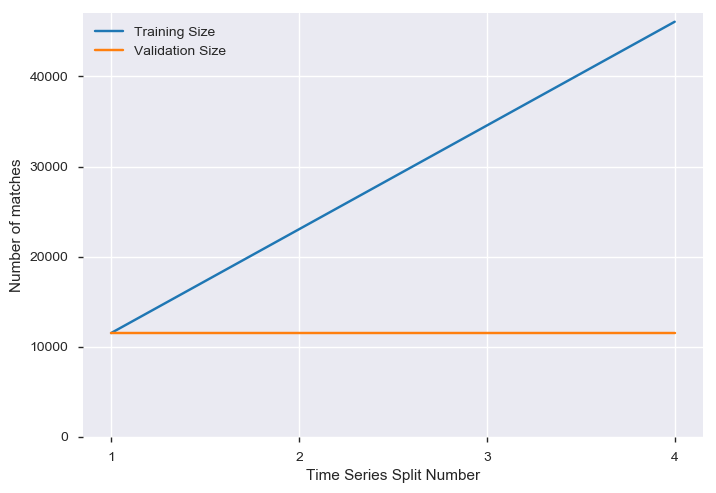

In [38]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from xgboost import plot_importance, plot_tree
from matplotlib import pyplot
from skopt import BayesSearchCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
import time

t = time.process_time()

# Default XGBClassifier settings, with nthread=-1 to speed up performance
clf = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, 
                    silent=True, objective='binary:logistic', 
                    booster='gbtree', n_jobs=-1, nthread=-1, gamma=0, 
                    min_child_weight=1, max_delta_step=0, 
                    subsample=1, colsample_bytree=1, colsample_bylevel=1, 
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, 
                    base_score=0.5, random_state=0, seed=None, missing=None)

tss = TimeSeriesSplit(n_splits = 4)
tss_split_length=[]
tss_test_length=[]
i=0
for train_index, test_index in tss.split(X_train):
    tss_split_length.append(train_index.shape[0])
    tss_test_length.append(test_index.shape[0])
    i+=1
    print("Split:", i, "Train Size:", train_index.shape[0], "Test Size:", test_index.shape[0])

# Plot tss splits
pyplot.figure()
pyplot.xlabel("Time Series Split Number")
pyplot.ylabel("Number of matches")
# pyplot.plot(tss_split_length, scores['train_neg_log_loss'])
# pyplot.plot(tss_split_length, scores['test_neg_log_loss'])
pyplot.plot(range(1, len(tss_split_length) + 1), tss_split_length, label='Training Size')
pyplot.plot(range(1, len(tss_test_length) + 1), tss_test_length, label='Validation Size')
# pyplot.plot(tss_split_length, scores['test_neg_log_loss'])
pyplot.legend(loc='upper left')
pyplot.xticks([1,2,3,4])
pyplot.ylim([0, 47000])
pyplot.show() 

### Default XGBoost Model

14.397315979003906
Max fit_time : 11.936 (mean 7.902 +/- 3.0818)
Max score_time : 0.060 (mean 0.052 +/- 0.0055)
Max test_neg_log_loss : -0.590 (mean -0.614 +/- 0.0156)
Max train_neg_log_loss : -0.592 (mean -0.603 +/- 0.0073)
Default XGBoost Model Learning Curve


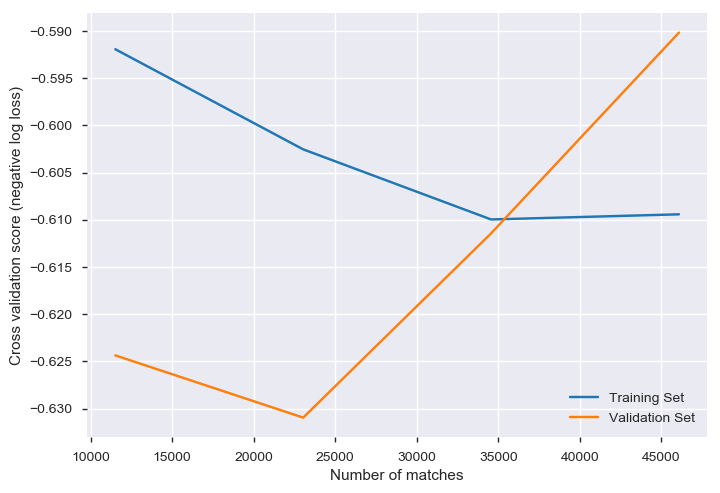

In [46]:
# source: https://stackoverflow.com/questions/37334631/improve-python-sklearn-crossvalidation-ouput
start = time.time()
scores = cross_validate(clf, X_train, y_train, 
                        cv=tss, 
                        return_train_score=True,
                        scoring=['neg_log_loss'], n_jobs=-1)
end = time.time()
print(end-start)

for key in scores.keys():
    print("Max %s : %0.3f (mean %0.3f +/- %0.4f)" % (key, scores[key].max(), scores[key].mean(), scores[key].std()))
    
print("Default XGBoost Model Learning Curve")
pyplot.figure()
pyplot.xlabel("Number of matches")
pyplot.ylabel("Cross validation score (negative log loss)")
pyplot.plot(tss_split_length, scores['train_neg_log_loss'], label='Training Set')
pyplot.plot(tss_split_length, scores['test_neg_log_loss'], label='Validation Set')
pyplot.legend(loc='lower right')
# pyplot.ylim([-0.65, 0])
pyplot.show()

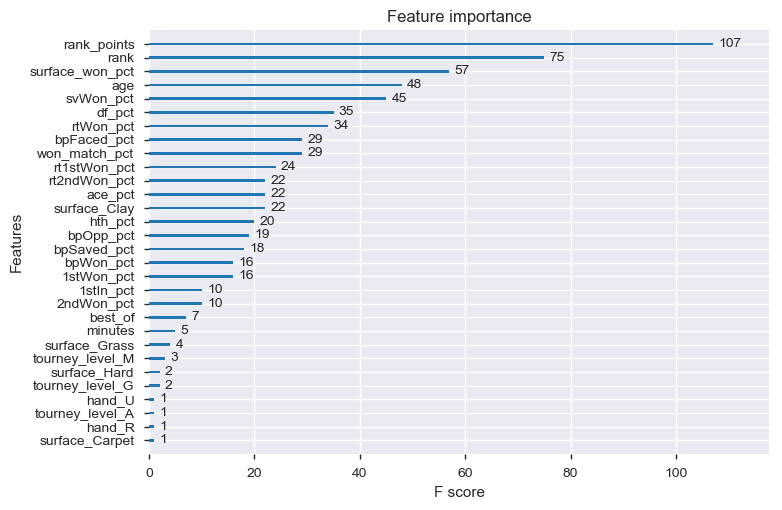

In [44]:
clf.fit(X_train, y_train)
plot_importance(clf)
pyplot.show()

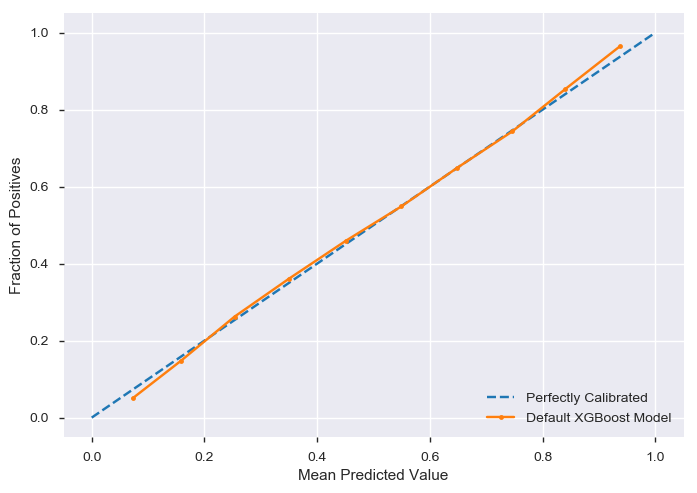

In [26]:
from sklearn.calibration import calibration_curve

# Source: https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/

fop, mpv = calibration_curve(y_train, clf.predict_proba(X_train)[:,1], n_bins=10, normalize=True)

# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
# plot model reliability
pyplot.plot(mpv, fop, marker='.', label='Default XGBoost Model')
pyplot.ylabel("Fraction of Positives")
pyplot.xlabel("Mean Predicted Value")
pyplot.legend(loc='lower right')
pyplot.show()

### Optimized XGBoost Model

In [27]:
# Optimized hyperparameter tuning

# source: https://github.com/scikit-optimize/scikit-optimize/blob/master/examples/sklearn-gridsearchcv-replacement.ipynb
start = time.time()

clf_opt = BayesSearchCV(clf, 
                        {'learning_rate': (0.001, 0.3, 'log-uniform'),
                         'min_child_weight': (1, 20),
                         'n_estimators': (100, 1500),
                         'max_depth': (1, 10),
                         'gamma': (1e-6, 10, 'log-uniform'),
                         'subsample': (0.5, 1.0),
                         'colsample_bytree': (0.5, 1.0), 
                         'reg_alpha': (1e-5, 10, 'log-uniform')},
                        n_iter=25, cv=tss, n_jobs=-1, scoring='neg_log_loss', 
                        random_state=1)

clf_opt.fit(X_train, y_train)
end = time.time()
print(end-start)

print("val. score: %s" % clf_opt.best_score_)
print(clf_opt.best_estimator_)
clf_opt = clf_opt.best_estimator_

# XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=0.5, gamma=6.049357830499676e-05,
#        learning_rate=0.0057687602128389985, max_delta_step=0, max_depth=3,
#        min_child_weight=2, missing=None, n_estimators=1500, n_jobs=-1,
#        nthread=-1, objective='binary:logistic', random_state=0,
#        reg_alpha=0.005594864803612525, reg_lambda=1, scale_pos_weight=1,
#        seed=None, silent=True, subsample=0.5863405251130618)

# XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=0.5, gamma=10.0,
#        learning_rate=0.014668915557751905, max_delta_step=0, max_depth=5,
#        min_child_weight=20, missing=None, n_estimators=1500, n_jobs=-1,
#        nthread=-1, objective='binary:logistic', random_state=0,
#        reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=None,
#        silent=True, subsample=0.5)

3024.338670015335
val. score: -0.6124713696912029
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=10.0,
       learning_rate=0.014668915557751905, max_delta_step=0, max_depth=5,
       min_child_weight=20, missing=None, n_estimators=1500, n_jobs=-1,
       nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=6.049357830499676e-05,
       learning_rate=0.0057687602128389985, max_delta_step=0, max_depth=3,
       min_child_weight=2, missing=None, n_estimators=1500, n_jobs=-1,
       nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0.005594864803612525, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.5863405251130618)

In [30]:
# Hard coded version of clf_opt.best_estimator_ to prevent having to refit each time 
# clf_opt = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#                         colsample_bytree=0.5, gamma=10.0,learning_rate=0.014668915557751905, 
#                         max_delta_step=0, max_depth=5, min_child_weight=20, 
#                         missing=None, n_estimators=1500, n_jobs=-1, nthread=-1, 
#                         objective='binary:logistic', random_state=0, reg_alpha=1e-05, 
#                         reg_lambda=1, scale_pos_weight=1, seed=None, silent=True, 
#                         subsample=0.5)

129.23511409759521
Max fit_time : 123.753 (mean 78.013 +/- 34.4651)
Max score_time : 0.767 (mean 0.654 +/- 0.0824)
Max test_neg_log_loss : -0.588 (mean -0.612 +/- 0.0161)
Max train_neg_log_loss : -0.593 (mean -0.598 +/- 0.0034)
Optimized XGBoost Model Learning Curve


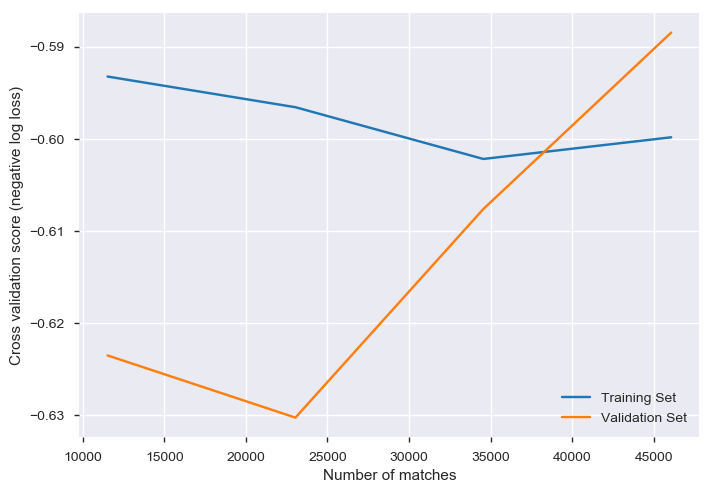

In [33]:
# Obtain cross validated scores

# source: https://stackoverflow.com/questions/37334631/improve-python-sklearn-crossvalidation-ouput
start = time.time()
opt_scores = cross_validate(clf_opt, X_train, y_train, 
                        cv=tss, 
                        return_train_score=True,
                        scoring=['neg_log_loss'], n_jobs=-1)
end = time.time()
print(end-start)

for key in opt_scores.keys():
    print("Max %s : %0.3f (mean %0.3f +/- %0.4f)" % (key, opt_scores[key].max(), opt_scores[key].mean(), opt_scores[key].std()))
    
print("Optimized XGBoost Model Learning Curve")
# Plot number of features VS. cross-validation scores
pyplot.figure()
pyplot.xlabel("Number of matches")
pyplot.ylabel("Cross validation score (negative log loss)")
pyplot.plot(tss_split_length, opt_scores['train_neg_log_loss'], label='Training Set')
pyplot.plot(tss_split_length, opt_scores['test_neg_log_loss'], label='Validation Set')
pyplot.legend(loc='lower right')
pyplot.show() 

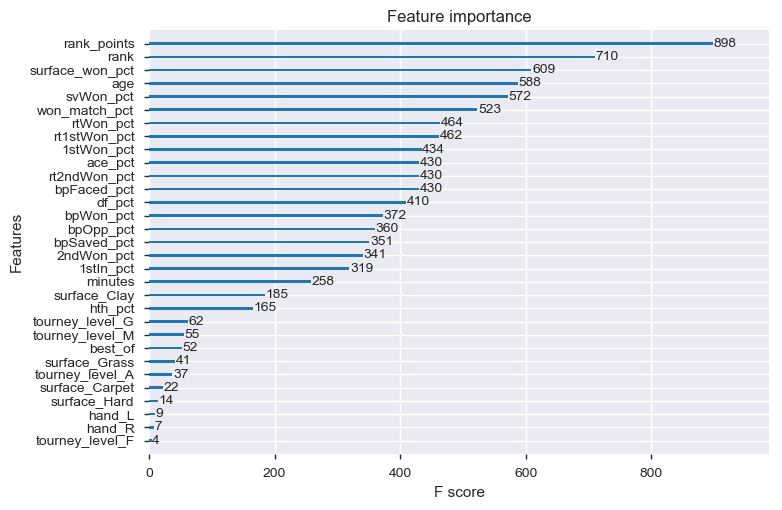

In [34]:
# Plot feature importances
clf_opt.fit(X_train, y_train)
plot_importance(clf_opt)
pyplot.show()

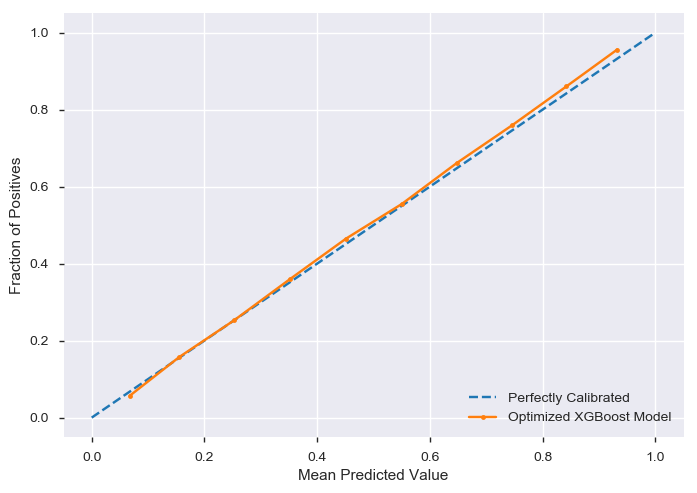

In [35]:
# Plot calibration curve

# Source: https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/

fop, mpv = calibration_curve(y_train, clf_opt.predict_proba(X_train)[:,1], n_bins=10, normalize=True)

# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
# plot model reliability
pyplot.plot(mpv, fop, marker='.', label='Optimized XGBoost Model')
pyplot.ylabel("Fraction of Positives")
pyplot.xlabel("Mean Predicted Value")
pyplot.legend(loc='lower right')
pyplot.show()

### Optimized XGBoost with Reduced Features

In [36]:
# Remove features with low feature importance values
X_train_reduced = (
    X_train.drop(['tourney_level_G', 'tourney_level_A', 'tourney_level_M', 
                   'tourney_level_D', 'tourney_level_C', 'tourney_level_F', 
                   'surface_Grass', 'surface_Carpet', 'surface_Hard', 
                   'hand_L', 'hand_R', 'hand_U'], axis=1))
X_test_reduced = (
    X_test.drop(['tourney_level_G', 'tourney_level_A', 'tourney_level_M', 
                 'tourney_level_D', 'tourney_level_C', 'tourney_level_F', 
                 'surface_Grass', 'surface_Carpet', 'surface_Hard', 
                 'hand_L', 'hand_R', 'hand_U'], axis=1))

In [39]:
# Tune hyperparameters

# source: https://github.com/scikit-optimize/scikit-optimize/blob/master/examples/sklearn-gridsearchcv-replacement.ipynb

start = time.time()
clf_opt_red = BayesSearchCV(clf, 
                            {'learning_rate': (0.001, 0.3, 'log-uniform'),
                             'min_child_weight': (1, 20),
                             'n_estimators': (100, 1500),
                             'max_depth': (1, 10),
                             'gamma': (1e-6, 10, 'log-uniform'),
                             'subsample': (0.5, 1.0),
                             'colsample_bytree': (0.5, 1.0), 
                             'reg_alpha': (1e-5, 10, 'log-uniform')},
                            n_iter=25, cv=tss, n_jobs=-1, scoring='neg_log_loss', 
                            random_state=1)

clf_opt_red.fit(X_train_reduced, y_train)
end = time.time()
print(end-start)

print("val. score: %s" % clf_opt_red.best_score_)
print(clf_opt_red.best_estimator_)
clf_opt_red = clf_opt_red.best_estimator_

# XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=0.5, gamma=10.0,
#        learning_rate=0.0034126039328430426, max_delta_step=0, max_depth=10,
#        min_child_weight=1, missing=None, n_estimators=1500, n_jobs=-1,
#        nthread=-1, objective='binary:logistic', random_state=0,
#        reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=None,
#        silent=True, subsample=0.7396835114478809)

2811.9363708496094
val. score: -0.612792803169143
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=10.0,
       learning_rate=0.0034126039328430426, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=1500, n_jobs=-1,
       nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7396835114478809)


In [ ]:
# Hard coded version of clf_opt_red.best_estimator_ to prevent having to refit each time 
# clf_opt_red = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=0.5, gamma=10.0,
#        learning_rate=0.0034126039328430426, max_delta_step=0, max_depth=10,
#        min_child_weight=1, missing=None, n_estimators=1500, n_jobs=-1,
#        nthread=-1, objective='binary:logistic', random_state=0,
#        reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=None,
#        silent=True, subsample=0.7396835114478809)

218.43077683448792
Max fit_time : 206.331 (mean 131.619 +/- 56.6637)
Max score_time : 1.995 (mean 1.871 +/- 0.1353)
Max test_neg_log_loss : -0.589 (mean -0.613 +/- 0.0158)
Max train_neg_log_loss : -0.578 (mean -0.584 +/- 0.0040)
Optimized and Reduced XGBoost Model Learning Curve


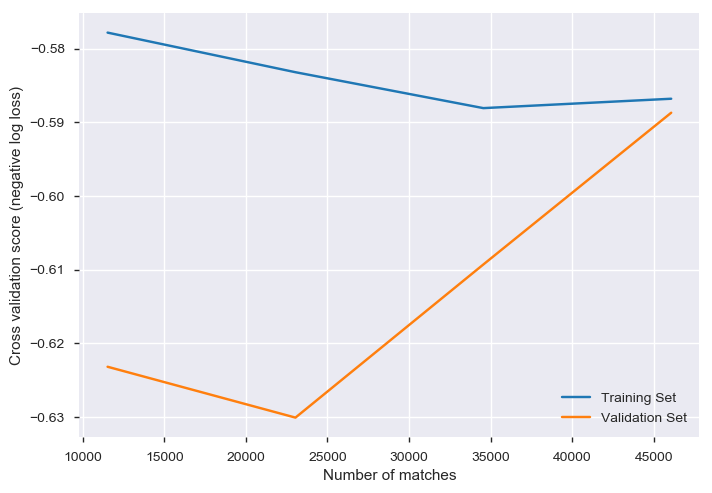

In [40]:
# Obtain cross validated scores
# source: https://stackoverflow.com/questions/37334631/improve-python-sklearn-crossvalidation-ouput
start = time.time()
opt_red_scores = cross_validate(clf_opt_red, X_train_reduced, y_train, 
                                cv=tss, 
                                return_train_score=True,
                                scoring=['neg_log_loss'], n_jobs=-1)
end = time.time()
print(end-start)

for key in opt_red_scores.keys():
    print("Max %s : %0.3f (mean %0.3f +/- %0.4f)" % (key, opt_red_scores[key].max(), opt_red_scores[key].mean(), opt_red_scores[key].std()))
    
print("Optimized and Reduced XGBoost Model Learning Curve")
# Plot number of features VS. cross-validation scores
pyplot.figure()
pyplot.xlabel("Number of matches")
pyplot.ylabel("Cross validation score (negative log loss)")
pyplot.plot(tss_split_length, opt_red_scores['train_neg_log_loss'], label='Training Set')
pyplot.plot(tss_split_length, opt_red_scores['test_neg_log_loss'], label='Validation Set')
pyplot.legend(loc='lower right')
pyplot.show() 

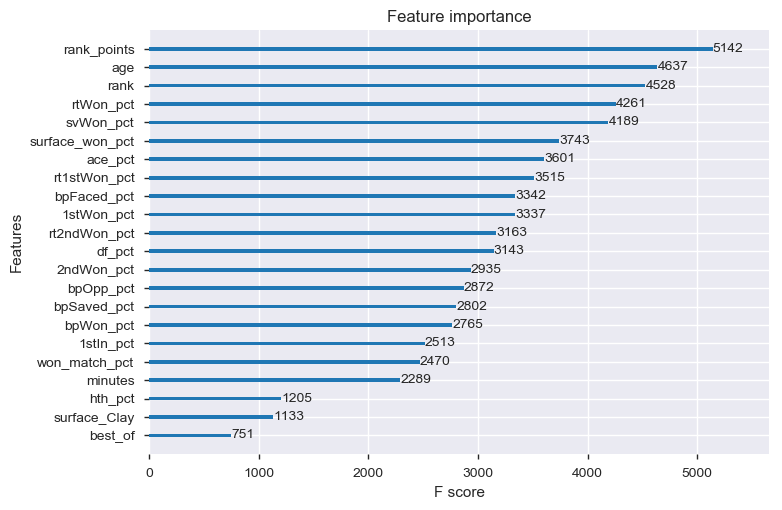

In [41]:
# Plot feature importances

clf_opt_red.fit(X_train_reduced, y_train)
plot_importance(clf_opt_red)
pyplot.show()

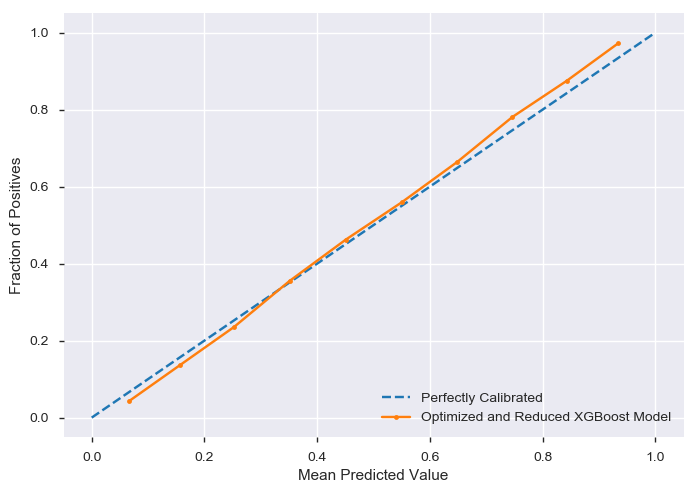

In [42]:
from sklearn.calibration import calibration_curve

# Source: https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/

fop, mpv = calibration_curve(y_train, clf_opt_red.predict_proba(X_train_reduced)[:,1], n_bins=10, normalize=True)

# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
# plot model reliability
pyplot.plot(mpv, fop, marker='.', label='Optimized and Reduced XGBoost Model')
pyplot.ylabel("Fraction of Positives")
pyplot.xlabel("Mean Predicted Value")
pyplot.legend(loc='lower right')
pyplot.show()

### Test Set Scores

In [45]:
print("Default XGBoost test score: %s" % log_loss(y_test, clf.predict_proba(X_test)))
print("Optimized XGBoost test score: %s" % log_loss(y_test, clf_opt.predict_proba(X_test)))
print("Optimized XGBoost with reduced features test score: %s" % log_loss(y_test, clf_opt_red.predict_proba(X_test_reduced)))


# Default XGBoost test score: 0.5829260262331689
# Optimized XGBoost test score: 0.5826821889057954
# Optimized XGBoost with reduced features test score: 0.5820258993883017

Default XGBoost test score: 0.5831611543385483
Optimized XGBoost test score: 0.58154004303971
Optimized XGBoost with reduced features test score: 0.5820011298494985


In [52]:
# Remove subsets of training data to test for impact on results
perturbed = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=10.0,
       learning_rate=0.0034126039328430426, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=4, objective='binary:logistic', random_state=0,
       reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7396835114478809)

perturbed_scores = []

for year in train_validation['tourney_year'].unique():
    X_train_perturbed = X_train_reduced[train_validation['tourney_year'] != year]
    y_train_perturbed = y_train[train_validation['tourney_year'] != year]
    perturbed.fit(X_train_perturbed, y_train_perturbed)
    score = log_loss(y_test, perturbed.predict_proba(X_test_reduced))
    perturbed_scores.append(score)
    print('Year:', year, 'Score:', score)

# Year: 1991 Score: 0.5822993204572732
# Year: 1992 Score: 0.581877222028901
# Year: 1993 Score: 0.5821579595687607
# Year: 1994 Score: 0.582104583991788
# Year: 1995 Score: 0.5823495703333789
# Year: 1996 Score: 0.5823876310217814
# Year: 1997 Score: 0.5824614801473796
# Year: 1998 Score: 0.5824627695341716
# Year: 1999 Score: 0.5819508048285239
# Year: 2000 Score: 0.5818254943875223
# Year: 2001 Score: 0.5817393269786886
# Year: 2002 Score: 0.5823846907408075
# Year: 2003 Score: 0.582380738447001
# Year: 2004 Score: 0.582417493675196
# Year: 2005 Score: 0.5822010774073868
# Year: 2006 Score: 0.5818915122495358
# Year: 2007 Score: 0.5826040102679723
# Year: 2008 Score: 0.5821264912698364
# Year: 2009 Score: 0.5826369706276621

Year: 1991 Score: 0.5822759984172435
Year: 1992 Score: 0.5820458940426964
Year: 1993 Score: 0.5820404683992979
Year: 1994 Score: 0.5821330243924442
Year: 1995 Score: 0.5822106923240115
Year: 1996 Score: 0.5823469927623511
Year: 1997 Score: 0.5822017675045517
Year: 1998 Score: 0.5820073735275632
Year: 1999 Score: 0.5819675208147304
Year: 2000 Score: 0.5821519629715646
Year: 2001 Score: 0.5818900604980934
Year: 2002 Score: 0.5821418297206203
Year: 2003 Score: 0.5822056022107819
Year: 2004 Score: 0.582335852549608
Year: 2005 Score: 0.582041727281998
Year: 2006 Score: 0.5821955275720612
Year: 2007 Score: 0.5823592894014273
Year: 2008 Score: 0.5826376060360318
Year: 2009 Score: 0.5824741988174449
Year: 2010 Score: 0.581971304198779


In [53]:
perturbed_scores_df = pd.DataFrame(perturbed_scores)
print("Max : %0.3f (mean %0.3f +/- %0.4f)" % (perturbed_scores_df.max(), perturbed_scores_df.mean(), perturbed_scores_df.std()))



Max : 0.583 (mean 0.582 +/- 0.0002)


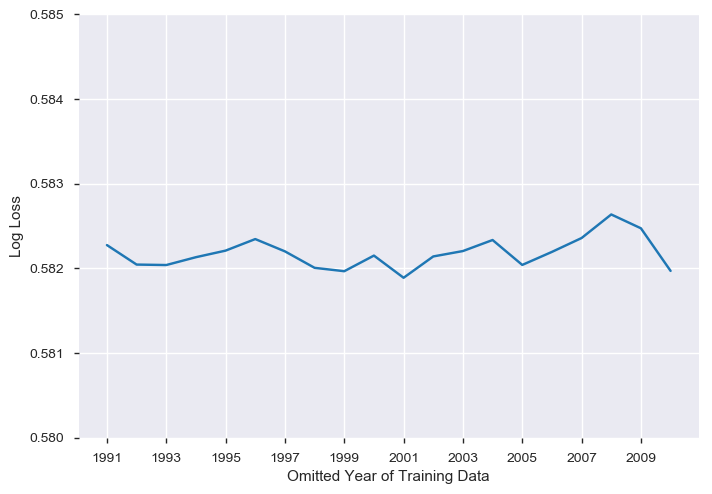

In [54]:
# Plot perturbations
pyplot.figure()
pyplot.xlabel("Omitted Year of Training Data")
pyplot.ylabel("Log Loss")
pyplot.plot(train_validation['tourney_year'].unique(), perturbed_scores, label='Perturbed Scores')
# pyplot.plot(tss_split_length, scores['test_neg_log_loss'])
# pyplot.legend(loc='upper left')
pyplot.xticks([1991, 1993, 1995, 1997, 1999, 2001, 2003, 2005, 2007, 2009])
pyplot.ylim([0.58, 0.585])
pyplot.show() 

In [ ]:
perturbed